<a href="https://colab.research.google.com/github/sidusit/MTech-Dissertation/blob/main/ARIMA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 14.3 MB/s 
     |████████████████████████████████| 9.8 MB 32.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
TCS = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Database/Indian/TCS_PreProcessed.csv")
HUL = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Database/Indian/MARUTI_PreProcessed.csv")
HUL = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Database/Indian/HUL_PreProcessed.csv")
MARUTI = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Database/Indian/MARUTI_PreProcessed.csv")

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series and help us understand if the series is stationary.

**Null Hypothesis**: The series has a unit root

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the Null Hypothesis, then the series is non-stationary.

In [ ]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['adj close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

#TCS

In [ ]:
TCS.head(20)

,ticker,date,open,high,low,close,adj close,volume,Moving Average for 10 days,Moving Average for 20 days,Moving Average for 50 days,Daily Return
0,TCS.NS,2019-01-01,1896.0,1910.00,1885.00,1902.80,1788.18,1094883.0,NaN,NaN,NaN,NaN
1,TCS.NS,2019-01-02,1905.0,1934.45,1900.00,1923.30,1807.44,2100463.0,NaN,NaN,NaN,0.010771
2,TCS.NS,2019-01-03,1919.0,1944.95,1893.10,1899.95,1785.50,2611668.0,NaN,NaN,NaN,-0.012139
3,TCS.NS,2019-01-04,1900.0,1901.20,1841.00,1876.85,1763.79,4280862.0,NaN,NaN,NaN,-0.012159
4,TCS.NS,2019-01-07,1891.8,1908.80,1881.00,1897.90,1783.57,1856423.0,NaN,NaN,NaN,0.011214
5,TCS.NS,2019-01-08,1905.4,1906.40,1883.30,1893.55,1779.48,1691756.0,NaN,NaN,NaN,-0.002293
6,TCS.NS,2019-01-09,1907.4,1919.00,1866.70,1886.95,1773.28,2414376.0,NaN,NaN,NaN,-0.003484
7,TCS.NS,2019-01-10,1890.0,1905.00,1872.10,1888.55,1774.78,3053461.0,NaN,NaN,NaN,0.000846
8,TCS.NS,2019-01-11,1870.0,1875.00,1835.00,1842.55,1731.56,9209862.0,NaN,NaN,NaN,-0.024352
9,TCS.NS,2019-01-14,1850.0,1851.00,1810.00,1813.25,1704.02,3615370.0,1769.160,NaN,NaN,-0.015905


In [ ]:
TCS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      697 non-null    object 
 1   date                        697 non-null    object 
 2   open                        697 non-null    float64
 3   high                        697 non-null    float64
 4   low                         697 non-null    float64
 5   close                       697 non-null    float64
 6   adj close                   697 non-null    float64
 7   volume                      697 non-null    float64
 8   Moving Average for 10 days  688 non-null    float64
 9   Moving Average for 20 days  678 non-null    float64
 10  Moving Average for 50 days  648 non-null    float64
 11  Daily Return                696 non-null    float64
dtypes: float64(10), object(2)
memory usage: 65.5+ KB


In [ ]:
# Change Dtype of date column
TCS["date"] = pd.to_datetime(TCS["date"])

In [ ]:
Test_Stationarity(TCS)

Results of Dickey Fuller Test
Test Statistics: -0.49167206183769324
p-value: 0.8936314177544171
Number of lags used: 0
Number of observations used: 696
critical value (1%): -3.4397804336105198
critical value (5%): -2.865701589065464
critical value (10%): -2.5689861435625576


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'adj close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

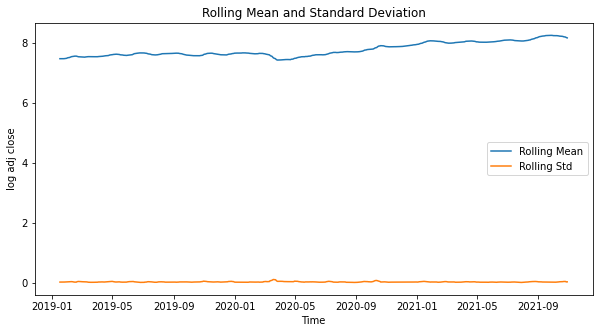

In [ ]:
TCS['log adj close'] = np.log(TCS['adj close'])
TCS_log_moving_avg = TCS['log adj close'].rolling(12).mean()
TCS_log_std = TCS['log adj close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(TCS['date'], TCS_log_moving_avg, label = "Rolling Mean")
plt.plot(TCS['date'], TCS_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log adj close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-20

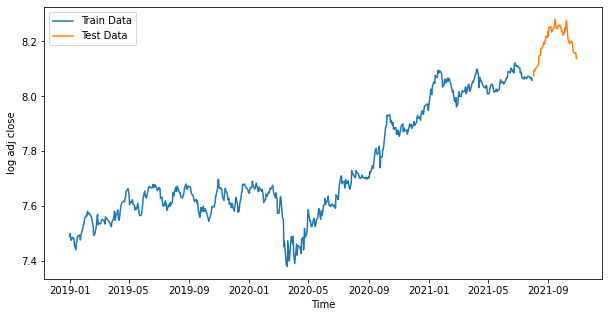

In [ ]:
TCS_Train_Data = TCS[TCS['date'] < '2021-08-01']
TCS_Test_Data = TCS[TCS['date'] >= '2021-08-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(TCS_Train_Data['date'], TCS_Train_Data['log adj close'], label = 'Train Data')
plt.plot(TCS_Test_Data['date'], TCS_Test_Data['log adj close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log adj close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
TCS_Auto_ARIMA_Model = auto_arima(TCS_Train_Data['log adj close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(TCS_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  635
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1660.827
Date:                Wed, 03 Nov 2021   AIC                          -3317.654
Time:                        08:53:50   BIC                          -3308.749
Sample:                             0   HQIC                         -3314.196
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0653      0.028     -2.320      0.020      -0.120      -0.010
sigma2         0.0003   9.75e-06     31.836      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [ ]:
TCS_ARIMA_Model = ARIMA(TCS_Train_Data['log adj close'], order = (1, 1, 0))
TCS_ARIMA_Model_Fit = TCS_ARIMA_Model.fit()
print(TCS_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:          log adj close   No. Observations:                  635
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1660.765
Date:                Wed, 03 Nov 2021   AIC                          -3317.530
Time:                        08:54:12   BIC                          -3308.626
Sample:                             0   HQIC                         -3314.073
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0634      0.028     -2.225      0.026      -0.119      -0.008
sigma2         0.0003   9.79e-06     31.717      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

###Predicting the closing stock price of TCS

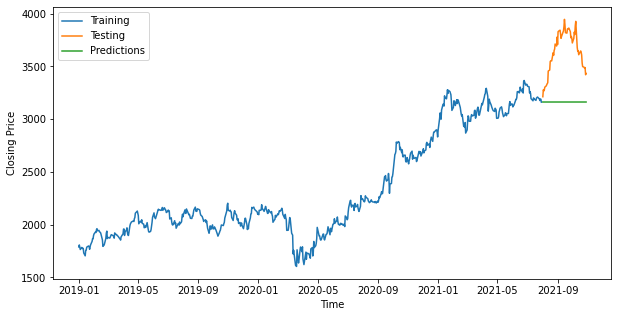

In [ ]:
TCS_output = TCS_ARIMA_Model_Fit.forecast(62, alpha=0.05)
TCS_predictions = np.exp(TCS_output.values)
plt.figure(figsize=(10, 5))
plt.plot(TCS_Train_Data['date'], TCS_Train_Data['adj close'], label = 'Training')
plt.plot(TCS_Test_Data['date'], TCS_Test_Data['adj close'], label = 'Testing')
plt.plot(TCS_Test_Data['date'], TCS_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(TCS_Test_Data['adj close'], TCS_predictions))
mape = np.mean(np.abs(TCS_predictions - TCS_Test_Data['adj close'])/np.abs(TCS_Test_Data['adj close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 522.2660125237351
MAPE: 0.13004634613206428


#HDFC

In [ ]:
HDFC.head(20)

,ticker,date,open,high,low,close,adj close,volume,Moving Average for 10 days,Moving Average for 20 days,Moving Average for 50 days,Daily Return
0,HDFC.NS,2019-01-01,1968.00,2014.70,1954.50,2009.00,1914.72,1305443.0,NaN,NaN,NaN,NaN
1,HDFC.NS,2019-01-02,2004.70,2009.00,1961.00,1980.65,1887.70,2001170.0,NaN,NaN,NaN,-0.014112
2,HDFC.NS,2019-01-03,1984.05,1987.10,1931.85,1936.85,1845.95,3732193.0,NaN,NaN,NaN,-0.022117
3,HDFC.NS,2019-01-04,1948.00,1976.00,1942.00,1972.60,1880.02,2109614.0,NaN,NaN,NaN,0.018457
4,HDFC.NS,2019-01-07,1976.95,1987.50,1963.95,1972.90,1880.31,2255477.0,NaN,NaN,NaN,0.000154
5,HDFC.NS,2019-01-08,1983.00,1983.00,1948.00,1958.95,1867.01,2061919.0,NaN,NaN,NaN,-0.007073
6,HDFC.NS,2019-01-09,1962.00,1998.00,1962.00,1994.95,1901.32,2905090.0,NaN,NaN,NaN,0.018377
7,HDFC.NS,2019-01-10,1993.00,1993.00,1971.30,1980.10,1887.17,2138302.0,NaN,NaN,NaN,-0.007442
8,HDFC.NS,2019-01-11,1978.00,2007.70,1972.40,1991.40,1897.94,1814132.0,NaN,NaN,NaN,0.005707
9,HDFC.NS,2019-01-14,1983.00,1983.15,1949.60,1969.20,1876.78,2167796.0,1883.892,NaN,NaN,-0.011149


In [ ]:
HDFC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      697 non-null    object 
 1   date                        697 non-null    object 
 2   open                        697 non-null    float64
 3   high                        697 non-null    float64
 4   low                         697 non-null    float64
 5   close                       697 non-null    float64
 6   adj close                   697 non-null    float64
 7   volume                      697 non-null    float64
 8   Moving Average for 10 days  688 non-null    float64
 9   Moving Average for 20 days  678 non-null    float64
 10  Moving Average for 50 days  648 non-null    float64
 11  Daily Return                696 non-null    float64
dtypes: float64(10), object(2)
memory usage: 65.5+ KB


In [ ]:
# Change Dtype of date column
HDFC["date"] = pd.to_datetime(HDFC["date"])

In [ ]:
Test_Stationarity(HDFC)

Results of Dickey Fuller Test
Test Statistics: -0.9437690011290609
p-value: 0.7732172926811722
Number of lags used: 8
Number of observations used: 688
critical value (1%): -3.439890503006147
critical value (5%): -2.865750085260771
critical value (10%): -2.569011980884938


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'adj close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

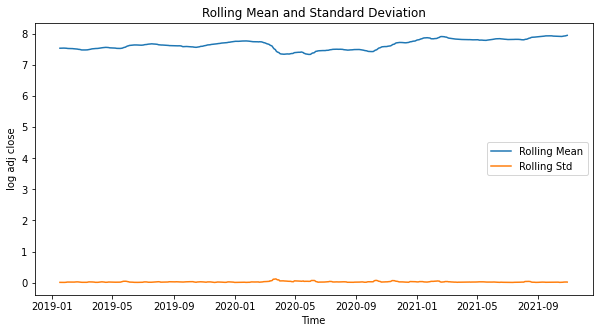

In [ ]:
HDFC['log adj close'] = np.log(HDFC['adj close'])
HDFC_log_moving_avg = HDFC['log adj close'].rolling(12).mean()
HDFC_log_std = HDFC['log adj close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(HDFC['date'], HDFC_log_moving_avg, label = "Rolling Mean")
plt.plot(HDFC['date'], HDFC_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log adj close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-20

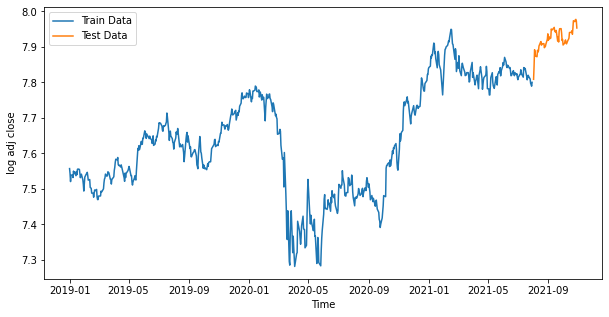

In [ ]:
HDFC_Train_Data = HDFC[HDFC['date'] < '2021-08-01']
HDFC_Test_Data = HDFC[HDFC['date'] >= '2021-08-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(HDFC_Train_Data['date'], HDFC_Train_Data['log adj close'], label = 'Train Data')
plt.plot(HDFC_Test_Data['date'], HDFC_Test_Data['log adj close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log adj close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
HDFC_Auto_ARIMA_Model = auto_arima(HDFC_Train_Data['log adj close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(HDFC_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  635
Model:               SARIMAX(3, 1, 0)   Log Likelihood                1497.258
Date:                Wed, 03 Nov 2021   AIC                          -2986.517
Time:                        08:57:37   BIC                          -2968.708
Sample:                             0   HQIC                         -2979.601
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0383      0.025     -1.536      0.125      -0.087       0.011
ar.L2         -0.0922      0.021     -4.475      0.000      -0.133      -0.052
ar.L3         -0.1276      0.021     -6.136      0.0

In [ ]:
HDFC_ARIMA_Model = ARIMA(HDFC_Train_Data['log adj close'], order = (1, 1, 0))
HDFC_ARIMA_Model_Fit = HDFC_ARIMA_Model.fit()
print(HDFC_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:          log adj close   No. Observations:                  635
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1489.523
Date:                Wed, 03 Nov 2021   AIC                          -2975.045
Time:                        08:58:07   BIC                          -2966.141
Sample:                             0   HQIC                         -2971.588
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0248      0.025     -1.008      0.313      -0.073       0.023
sigma2         0.0005   1.65e-05     32.387      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

###Predicting the closing stock price of HDFC

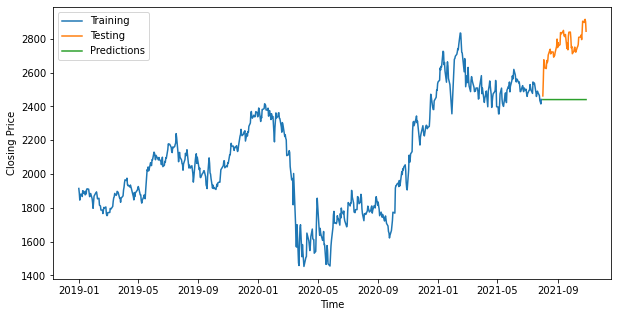

In [ ]:
HDFC_output = HDFC_ARIMA_Model_Fit.forecast(62, alpha=0.05)
HDFC_predictions = np.exp(HDFC_output.values)
plt.figure(figsize=(10, 5))
plt.plot(HDFC_Train_Data['date'], HDFC_Train_Data['adj close'], label = 'Training')
plt.plot(HDFC_Test_Data['date'], HDFC_Test_Data['adj close'], label = 'Testing')
plt.plot(HDFC_Test_Data['date'], HDFC_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(HDFC_Test_Data['adj close'], HDFC_predictions))
mape = np.mean(np.abs(HDFC_predictions - HDFC_Test_Data['adj close'])/np.abs(HDFC_Test_Data['adj close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 330.13414578370845
MAPE: 0.1149287808496038


#HUL

In [ ]:
HUL.head(20)

,ticker,date,open,high,low,close,adj close,volume,Moving Average for 10 days,Moving Average for 20 days,Moving Average for 50 days,Daily Return
0,HINDUNILVR.NS,2019-01-01,1824.8,1824.80,1798.35,1801.10,1735.48,807345.0,NaN,NaN,NaN,NaN
1,HINDUNILVR.NS,2019-01-02,1792.4,1808.85,1771.30,1784.60,1719.58,1598707.0,NaN,NaN,NaN,-0.009162
2,HINDUNILVR.NS,2019-01-03,1782.6,1803.45,1782.60,1788.40,1723.24,1182624.0,NaN,NaN,NaN,0.002128
3,HINDUNILVR.NS,2019-01-04,1798.9,1802.00,1772.15,1781.70,1716.78,1454134.0,NaN,NaN,NaN,-0.003749
4,HINDUNILVR.NS,2019-01-07,1791.5,1804.00,1782.45,1784.95,1719.91,909032.0,NaN,NaN,NaN,0.001823
5,HINDUNILVR.NS,2019-01-08,1792.0,1793.50,1761.10,1770.85,1706.33,1262707.0,NaN,NaN,NaN,-0.007896
6,HINDUNILVR.NS,2019-01-09,1777.5,1797.00,1773.40,1785.00,1719.96,1324628.0,NaN,NaN,NaN,0.007988
7,HINDUNILVR.NS,2019-01-10,1785.0,1799.10,1779.00,1786.20,1721.12,1313981.0,NaN,NaN,NaN,0.000674
8,HINDUNILVR.NS,2019-01-11,1795.0,1795.40,1758.55,1769.40,1704.93,1113837.0,NaN,NaN,NaN,-0.009407
9,HINDUNILVR.NS,2019-01-14,1771.0,1780.75,1760.10,1763.90,1699.63,1018068.0,1716.696,NaN,NaN,-0.003109


In [ ]:
HUL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      697 non-null    object 
 1   date                        697 non-null    object 
 2   open                        697 non-null    float64
 3   high                        697 non-null    float64
 4   low                         697 non-null    float64
 5   close                       697 non-null    float64
 6   adj close                   697 non-null    float64
 7   volume                      697 non-null    float64
 8   Moving Average for 10 days  688 non-null    float64
 9   Moving Average for 20 days  678 non-null    float64
 10  Moving Average for 50 days  648 non-null    float64
 11  Daily Return                696 non-null    float64
dtypes: float64(10), object(2)
memory usage: 65.5+ KB


In [ ]:
# Change Dtype of date column
HUL["date"] = pd.to_datetime(HUL["date"])

In [ ]:
Test_Stationarity(HUL)

Results of Dickey Fuller Test
Test Statistics: -1.8255838389567907
p-value: 0.3678360232703907
Number of lags used: 7
Number of observations used: 689
critical value (1%): -3.439876604020831
critical value (5%): -2.8657439615125675
critical value (10%): -2.5690087183208665


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'adj close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

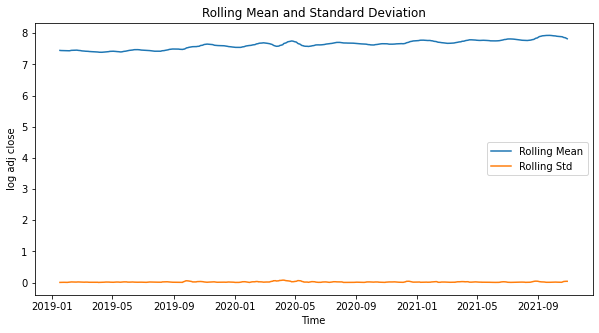

In [ ]:
HUL['log adj close'] = np.log(HUL['adj close'])
HUL_log_moving_avg = HUL['log adj close'].rolling(12).mean()
HUL_log_std = HUL['log adj close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(HUL['date'], HUL_log_moving_avg, label = "Rolling Mean")
plt.plot(HUL['date'], HUL_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log adj close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-20

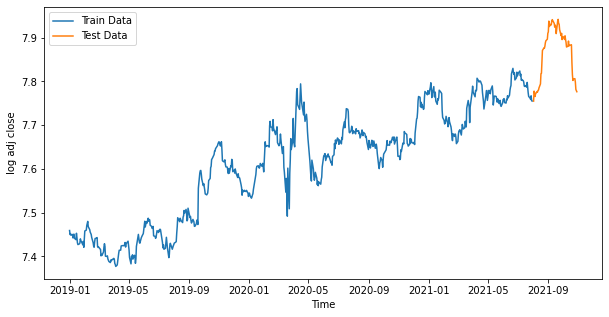

In [ ]:
HUL_Train_Data = HUL[HUL['date'] < '2021-08-01']
HUL_Test_Data = HUL[HUL['date'] >= '2021-08-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(HUL_Train_Data['date'], HUL_Train_Data['log adj close'], label = 'Train Data')
plt.plot(HUL_Test_Data['date'], HUL_Test_Data['log adj close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log adj close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
HUL_Auto_ARIMA_Model = auto_arima(HUL_Train_Data['log adj close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(HUL_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  635
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1710.835
Date:                Wed, 03 Nov 2021   AIC                          -3417.669
Time:                        09:01:15   BIC                          -3408.765
Sample:                             0   HQIC                         -3414.212
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1117      0.021     -5.240      0.000      -0.153      -0.070
sigma2         0.0003   6.73e-06     39.365      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [ ]:
HUL_ARIMA_Model = ARIMA(HUL_Train_Data['log adj close'], order = (1, 1, 0))
HUL_ARIMA_Model_Fit = HUL_ARIMA_Model.fit()
print(HUL_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:          log adj close   No. Observations:                  635
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1710.510
Date:                Wed, 03 Nov 2021   AIC                          -3417.021
Time:                        09:01:16   BIC                          -3408.117
Sample:                             0   HQIC                         -3413.563
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1028      0.020     -5.212      0.000      -0.141      -0.064
sigma2         0.0003   6.48e-06     40.968      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.03   Jarque-

###Predicting the closing stock price of HUL

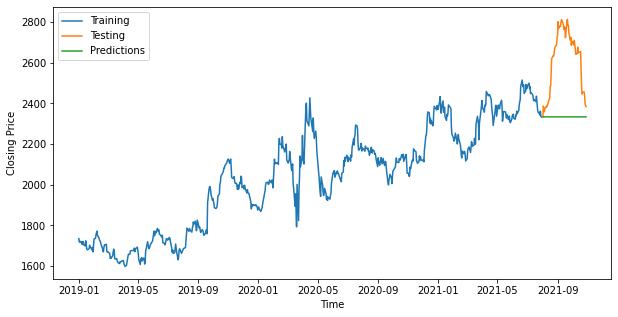

In [ ]:
HUL_output = HUL_ARIMA_Model_Fit.forecast(62, alpha=0.05)
HUL_predictions = np.exp(HUL_output.values)
plt.figure(figsize=(10, 5))
plt.plot(HUL_Train_Data['date'], HUL_Train_Data['adj close'], label = 'Training')
plt.plot(HUL_Test_Data['date'], HUL_Test_Data['adj close'], label = 'Testing')
plt.plot(HUL_Test_Data['date'], HUL_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(HUL_Test_Data['adj close'], HUL_predictions))
mape = np.mean(np.abs(HUL_predictions - HUL_Test_Data['adj close'])/np.abs(HUL_Test_Data['adj close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 317.0953048632128
MAPE: 0.10291463362188119


#MARUTI

In [ ]:
MARUTI.head(20)

,ticker,date,open,high,low,close,adj close,volume,Moving Average for 10 days,Moving Average for 20 days,Moving Average for 50 days,Daily Return
0,MARUTI.NS,2019-01-01,7449.75,7494.00,7395.00,7476.80,7261.91,625360.0,NaN,NaN,NaN,NaN
1,MARUTI.NS,2019-01-02,7445.00,7460.00,7244.00,7267.85,7058.96,891844.0,NaN,NaN,NaN,-0.027947
2,MARUTI.NS,2019-01-03,7280.00,7350.00,7185.60,7203.95,6996.90,715168.0,NaN,NaN,NaN,-0.008792
3,MARUTI.NS,2019-01-04,7239.00,7309.00,7161.20,7234.50,7026.57,774445.0,NaN,NaN,NaN,0.004240
4,MARUTI.NS,2019-01-07,7310.00,7407.00,7300.00,7362.05,7150.46,687845.0,NaN,NaN,NaN,0.017632
5,MARUTI.NS,2019-01-08,7380.00,7454.80,7322.10,7439.50,7225.68,516841.0,NaN,NaN,NaN,0.010520
6,MARUTI.NS,2019-01-09,7460.50,7529.00,7414.00,7492.90,7277.54,740580.0,NaN,NaN,NaN,0.007177
7,MARUTI.NS,2019-01-10,7500.00,7511.00,7360.15,7391.60,7179.16,452699.0,NaN,NaN,NaN,-0.013518
8,MARUTI.NS,2019-01-11,7382.70,7400.00,7282.00,7320.50,7110.10,488399.0,NaN,NaN,NaN,-0.009620
9,MARUTI.NS,2019-01-14,7330.00,7433.35,7257.00,7408.70,7195.76,424152.0,7148.304,NaN,NaN,0.012048


In [ ]:
MARUTI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      697 non-null    object 
 1   date                        697 non-null    object 
 2   open                        697 non-null    float64
 3   high                        697 non-null    float64
 4   low                         697 non-null    float64
 5   close                       697 non-null    float64
 6   adj close                   697 non-null    float64
 7   volume                      697 non-null    float64
 8   Moving Average for 10 days  688 non-null    float64
 9   Moving Average for 20 days  678 non-null    float64
 10  Moving Average for 50 days  648 non-null    float64
 11  Daily Return                696 non-null    float64
dtypes: float64(10), object(2)
memory usage: 65.5+ KB


In [ ]:
# Change Dtype of date column
MARUTI["date"] = pd.to_datetime(MARUTI["date"])

In [ ]:
Test_Stationarity(MARUTI)

Results of Dickey Fuller Test
Test Statistics: -2.4070570596536447
p-value: 0.13975450455461352
Number of lags used: 0
Number of observations used: 696
critical value (1%): -3.4397804336105198
critical value (5%): -2.865701589065464
critical value (10%): -2.5689861435625576


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'adj close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

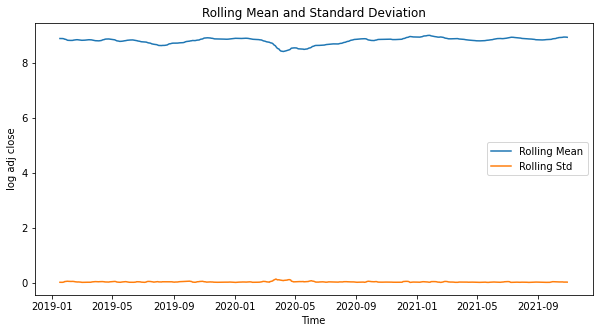

In [ ]:
MARUTI['log adj close'] = np.log(MARUTI['adj close'])
MARUTI_log_moving_avg = MARUTI['log adj close'].rolling(12).mean()
MARUTI_log_std = MARUTI['log adj close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(MARUTI['date'], MARUTI_log_moving_avg, label = "Rolling Mean")
plt.plot(MARUTI['date'], MARUTI_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log adj close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-20

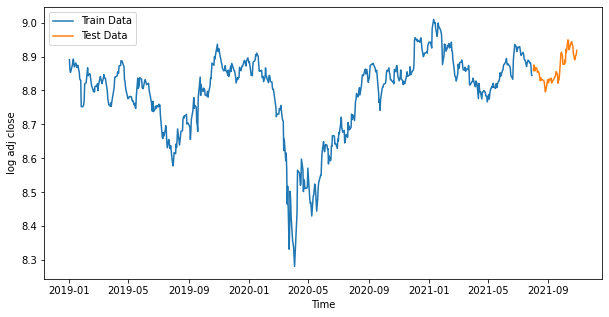

In [ ]:
MARUTI_Train_Data = MARUTI[MARUTI['date'] < '2021-08-01']
MARUTI_Test_Data = MARUTI[MARUTI['date'] >= '2021-08-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(MARUTI_Train_Data['date'], MARUTI_Train_Data['log adj close'], label = 'Train Data')
plt.plot(MARUTI_Test_Data['date'], MARUTI_Test_Data['log adj close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log adj close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
MARUTI_Auto_ARIMA_Model = auto_arima(MARUTI_Train_Data['log adj close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(MARUTI_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  635
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1479.601
Date:                Wed, 03 Nov 2021   AIC                          -2957.202
Time:                        09:02:59   BIC                          -2952.750
Sample:                             0   HQIC                         -2955.473
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   1.23e-05     44.726      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.41   Jarque-Bera (JB):              2987.45
Prob(Q):                              0.24   Pr

In [ ]:
MARUTI_ARIMA_Model = ARIMA(MARUTI_Train_Data['log adj close'], order = (1, 1, 0))
MARUTI_ARIMA_Model_Fit = MARUTI_ARIMA_Model.fit()
print(MARUTI_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:          log adj close   No. Observations:                  635
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1480.302
Date:                Wed, 03 Nov 2021   AIC                          -2956.604
Time:                        09:02:59   BIC                          -2947.700
Sample:                             0   HQIC                         -2953.146
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0470      0.024     -1.951      0.051      -0.094       0.000
sigma2         0.0005   1.27e-05     43.225      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

###Predicting the closing stock price of MARUTI

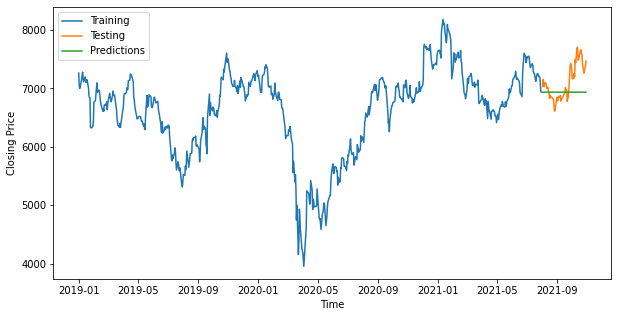

In [ ]:
MARUTI_output = MARUTI_ARIMA_Model_Fit.forecast(62, alpha=0.05)
MARUTI_predictions = np.exp(MARUTI_output.values)
plt.figure(figsize=(10, 5))
plt.plot(MARUTI_Train_Data['date'], MARUTI_Train_Data['adj close'], label = 'Training')
plt.plot(MARUTI_Test_Data['date'], MARUTI_Test_Data['adj close'], label = 'Testing')
plt.plot(MARUTI_Test_Data['date'], MARUTI_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(MARUTI_Test_Data['adj close'], MARUTI_predictions))
mape = np.mean(np.abs(MARUTI_predictions - MARUTI_Test_Data['adj close'])/np.abs(MARUTI_Test_Data['adj close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 338.23377951146995
MAPE: 0.035429692451873725
